# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


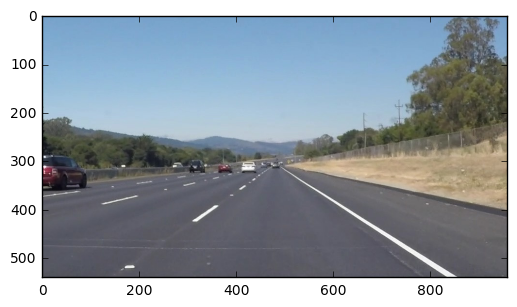

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
################################################################################################################
# Author for this block of code: Sagar Bhokre                                                                  #
# Functions implemented: show_image() draw_lines() slope_line() init_globals() process_image()                 #
################################################################################################################

#################################################################################################################
# Function: show_image() Visualize image data                                                                   #
# params: [i/p] name - window name                                                                              #
#         [o/p] image- image data                                                                               #
#################################################################################################################
def show_image(name, image):
    plt.imshow(image)
    #cv2.imshow(name, image)

#################################################################################################################
# Function: draw_lines() Draw lane markings on top of input image by fitting a line using linear regression     #
# params: [i/p] img - input image on which lane markings have to be drawn                                       #
#         [i/p] lines - Lines extracted using hough transform on canny edge detected input in grayscale format  #
#         [i/p] color - color of lane marking to be drawn ([optional] default = red)                            #
#         [i/p] thickness - thickness of lane marking ([optional] default = 2)                                  #
#         [o/p] 0 - if both lane markings were detected                                                         #
#               1 - if one or less lane markings were detected                                                  #
# Description: Split lines segments detected using hough transform into left and right lane using their slope.  #
#              Fit a line passing through left and right lines separately using linear regression               #
#               Extrapolate to the top and bottom of lane marking zone                                          #
#              Also keep a track of the last frames intercepts to smoothen out lane markings                    #
#################################################################################################################
prev_left_l, prev_left_u, prev_right_l, prev_right_u = 0, 0, 0, 0
from scipy import stats
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    x_l, y_l, x_r, y_r = [], [], [] ,[]
    global prev_left_l, prev_left_u, prev_right_l, prev_right_u

    y1 = int(1.1 * YU)
    y2 = H
    weight_u = 0.8
    weight_l = 0.8
    if (debug == 1):
        for line in lines:
            for (x1, y1, x2, y2) in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness=2)

    for line in lines:
        slope = slope_line(line)

        # Filter out left lane markers ensuring none of the points cross right top x boundary
        if((slope > SLOPE_THRESHOLD) and (line[0][0] > (W/2 - XU_OFFSET))):
            x_r.append(line[0][0])
            x_r.append(line[0][2])
            y_r.append(line[0][1])
            y_r.append(line[0][3])
        # Filter out right lane markers ensuring none of the points cross left top x boundary
        elif((slope < (-1 * SLOPE_THRESHOLD)) and (line[0][0] < (W/2 + XU_OFFSET))):
            x_l.append(line[0][0])
            x_l.append(line[0][2])
            y_l.append(line[0][1])
            y_l.append(line[0][3])

    # Plot left lane marker
    if((len(x_l) != 0) and (len(y_l) != 0)):
        slope_l, intercept_l, r_value, p_value, std_err = stats.linregress(x_l,y_l)
        x1 = int((y1 - intercept_l)/slope_l)
        x2 = int((y2 - intercept_l)/slope_l)
        if(prev_left_l == 0):
            prev_left_u = x1
            prev_left_l = x2
        xa = int(x1 * weight_u + prev_left_u * (1.0 - weight_u))
        xb = int(x2 * weight_l + prev_left_l * (1.0 - weight_l))
        cv2.line(img, (xa, y1), (xb, y2), color, thickness=8)
    
        prev_left_u = x1
        prev_left_l = x2
    
    # Plot right lane marker
    if((len(x_r) != 0) and (len(y_r) != 0)):
        slope_r, intercept_r, r_value, p_value, std_err = stats.linregress(x_r,y_r)
        x1 = int((y1 - intercept_r)/slope_r)
        x2 = int((y2 - intercept_r)/slope_r)
        if(prev_right_l == 0):
            print("init prev params")
            prev_right_u = x1
            prev_right_l = x2
        xa = int(x1 * weight_u + prev_right_u * (1.0 - weight_u))
        xb = int(x2 * weight_l + prev_right_l * (1.0 - weight_l))
        cv2.line(img, (xa, y1), (xb, y2), color, thickness=8)

        prev_right_u = x1
        prev_right_l = x2
    
    # Try to detect both lane markers and return 1 if either/both are missing
    if((len(x_l) == 0) or (len(x_r) == 0)):
        if(debug == 1):
            for line in lines:
                for (x1, y1, x2, y2) in line:
                    cv2.line(img, (x1, y1), (x2, y2), color=[255, 255, 255], thickness=2)
                    print(slope_line(line))
                    cv2.imshow("Lines_internal_debug", img)
                    cv2.waitKey(0)
        missing_markers = (len(x_l) == 0) + (len(x_r) == 0)
        print(str(missing_markers) + " lane markers not detected for frame " + str(frame))
        return 1

    #return 0 if both lane markers were detected
    return 0

#################################################################################################################
# Function: slope_line()) Calculate slope of the line passing through points mentioned in the arguments         #
# params: [i/p] line - coordinates of points passing through a line format: (x1, y1, x2, y2)                    #
#         [o/p] slope - slope of the line passing through the points mentioned in input parameter               #
#################################################################################################################
def slope_line(line):
    dx = line[0][2] - line[0][0]
    dy = line[0][3] - line[0][1]
    return (dy/dx)

##################################################################################################################
# Global Parameter set for tuning performance of the algorithm                                                   #
##################################################################################################################

# Edge detection
CANNY_LOW = 50
CANNY_HIGH = 150

# Noise filter
GAUSS_KER = 3

# Hough transform params
HOUGH_THRESHOLD = 10
HOUGH_MIN_LEN = 20
HOUGH_MAX_GAP = 180

# Lane detection slope threshold
SLOPE_THRESHOLD = 0.4

# Image params: updated before detecting lanes
H = 0
W = 0
YU = 0
XU_OFFSET = 0
ROI_VERTICES = np.array([[0, 0], [0, 0], [0, 0], [0, 0]], np.int32)
frame = 0

debug = 0

#################################################################################################################
# Function: init_globals(image) Updates global parameters specific to input image                               #
# params: [i/p] image - input image to be operated on
#################################################################################################################
def init_globals(image):
    global H, W, YU, XU_OFFSET, global_init, ROI_VERTICES
    H = image.shape[0]
    W = image.shape[1]
    XU_OFFSET = int(W/25)
    YU = int(H/2 + H/12)
    xu1 = int(W/2 + XU_OFFSET)
    xu2 = int(W/2 - XU_OFFSET)
    xl1 = int(W/20)
    xl2 = int(W - W/20)
    ROI_VERTICES = np.array([[xl1, H], [xl2, H], [xu1, YU], [xu2, YU]], np.int32)

#################################################################################################################
# Function: process_image(image) Process input image and draw lane markings detected using the following algo   #
# params: [i/p] image - Input image to be operated on                                                           #
#         [o/p] weighted_image - output generated after processing input and detecting lane markings            #
#                                                                                                               #
# Algorithm:                                                                                                    #
#            Initialize variables                                                                               #
#            Create a copy of input image to be used while rendering final output containing lane markings      #
#            Extract region of importance(ROI) to reduce computations. Trapezoid with base as bottom of image   #
#            Convert input to grayscale image to reduce further computation                                     #
#            Create a mask to extract yellow regions in image (detect yellow lane markings in ROI)              #
#            Create a mask to extract white regions. This is done using thresholding on grayscale image         #
#            Combine the mask for yellow and white regions                                                      #
#            Extract yellow and white regions                                                                   #
#            Detect edges in this image using canny edge detection algorithm                                    #
#            Filter out noise using gaussian blur function                                                      #
#            Compute hough transform to find out lines in the filtered image                                    #
#            Fit lane markers for left and right lanes separately using lines detected from hough transform     #
#            Overlay lane markers on input image to highlight lane markings                                     #
#################################################################################################################
def process_image(image):
    # track the frame being operated on
    global frame
    frame = frame + 1

    # initialize global variables depending on image params
    init_globals(image)

    # create a copy of original image to render final output
    original_image = image.copy()

    # Extract part of image we are interested in to avoid unwanted computations
    image = region_of_interest(image, [ROI_VERTICES])

    # Convert to greyscale to avoid further computations
    image_grey = grayscale(image)

    # HSV representation of yellow is [30, 255, 255]
    # filtering out yellow with some delta colors around it
    hyl = np.array([20, 50, 50], dtype = "uint8")
    hyu = np.array([40, 255, 255], dtype="uint8")

    # Create a mask to extract yello color from frame
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask_y = cv2.inRange(image_hsv, hyl, hyu)

    # Extract white/bright color from greyscale image. This will give data for while lane markers
    mask_w = cv2.inRange(image_grey, 200, 255)

    # Combine the mask for white and yellow
    mask = cv2.bitwise_or(mask_w, mask_y)
    # Extract white and yellow colored pixels from image frame
    image_yw_mask = cv2.bitwise_and(image_grey, mask)

    # From grey image extract edges
    image_canny = canny(image_yw_mask, CANNY_LOW, CANNY_HIGH)

    # Blur out image to reduce effect of noise
    image_gb = gaussian_blur(image_canny, GAUSS_KER)

    # Find lines(lane markers) in the image which fit the edges detected by canny filter
    image_line = hough_lines(image_gb, 1, np.pi/180, HOUGH_THRESHOLD, HOUGH_MIN_LEN, HOUGH_MAX_GAP);

    # overlay the lane markers on original image
    image_weighted = weighted_img(image_line, original_image)

    # render final image
    show_image("Final", image_weighted)

    if(debug == 1):
        show_image("Input", image)
        cv2.imshow("Grey Input", image_grey)
        cv2.imshow("Yellow mask", mask_y)
        cv2.imshow("White mask", mask_w)
        cv2.imshow("Y + W Image", image_yw_mask)
        cv2.imshow("Canny edges", image_canny)
        cv2.imshow("Gaussian Blur", image_gb)
        show_image("Line", image_line)
        #cv2.waitKey(0)
        cv2.waitKey(1)
    return image_weighted

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg']

init prev params


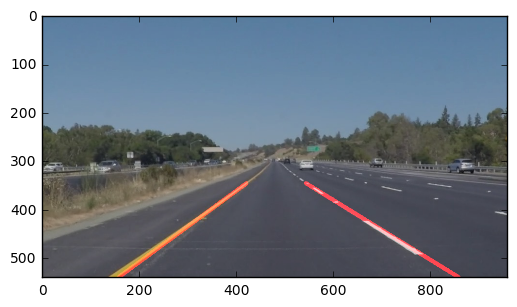

In [6]:
files = os.listdir("test_images/")
for filename in files:
    #reading in an image
    image = mpimg.imread('test_images/' + filename)
    output_image = process_image(image)
    mpimg.imsave('test_images/lanes_' + filename, output_image)

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:10<00:00, 20.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1min 14s, sys: 2.63 s, total: 1min 17s
Wall time: 11.3 s


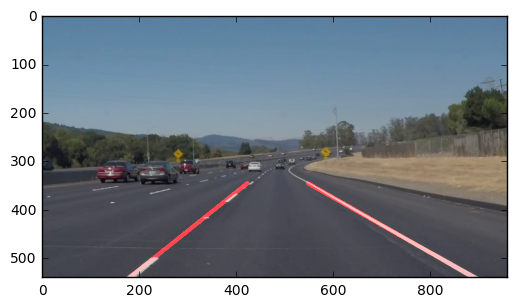

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:35<00:00, 19.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 3min 58s, sys: 8 s, total: 4min 6s
Wall time: 36.2 s


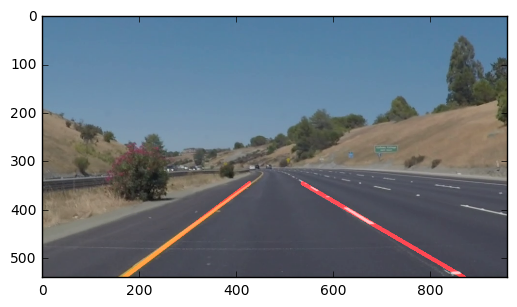

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

### Implementation details:

Algorithm can be split into following sub-blocks:

   1. Extract Region of interest to save computations.
      - Trapezoid with base as image width and height nearly spanning till the middle of image
      - Base width and top width were arrived at empirically
   2. Convert to grayscale to reduce further computations
   3. Create a mask for yellow and white areas in the image as lanes are usually demarked by white or yellow lines
   4. Extract yellow and white areas
   5. Extract edges from these areas using canny algorithm
   6. Remove noise effect by blurring out canny edge image with a kernel of size 3
   7. Find lines in this filtered image
   8. Split the lines into left and right lanes using the slope of these lines
   9. Fit a lane marking line passing through left and right set of lines we obtained from Hough transform
      - I have tried linear regression to fit the line passing through all points in a particular lane
      - Other methods could include passing a line through top and bottom points in a particular lane
   10. Overlay the lane markings on input image

#### Note: The algorithm informs with a print spew if it failed to detect one/both lane markings but continues to find lane markings in subsequent images

### Shortcomings and Suggestions for improving this algorithm:

  1. Output of the algorithm appears correct but not very smooth (This was the case with version 1)
     - Average of y intercepts could be considered for smoothening out the lane markings 
     - Will be trying a second order filter to test this concept
       (Already implemented in current version of the algorithm)
  2. Weighted average could be considered to fit lane markings instead of linear regression. This would give more weightage to longer lines and hopefully fit the lane markings better
  3. This implementation could also be run through a video captured in various lighting conditions to test robustness
  4. It could also be tested in foggy climate, rains, shaded areas (as seen in challenge.mp4), wet roads. I believe the algorithm may not function very well in foggy climate and during heavy rains when the vision is blurred and occluded. It should however perform well during slight rains and on wet roads where the vision is not affected much.


### Running the code

To run the code, open P1.ipynb using jupyter notebook and execute cells one after the other or all in one go.

After the execution is complete, output for test images would be created in the same folder as "test_images/" but with file names prepended with "lanes_". Please delete all files with name starting with "lanes_" before running the algorithm again


### Tested with:
- test_images
- solidWhiteRight.mp4
- solidYellowLeft.mp4
- challenge.mp4

## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


 80%|███████▉  | 200/251 [00:19<00:05,  8.74it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))